1. 导入所需模块

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2. 读取数据集，并将数据集合并

In [3]:
ratings = pd.read_csv(
    "../datasets/ml-1m/ratings.dat",
    sep="::",
    names=["userId", "movieId", "rating", "timestamp"],
    engine="python",
)
movies = pd.read_csv(
    "../datasets/ml-1m/movies.dat",
    sep="::",
    names=["movieId", "title", "genres"],
    engine="python",
)
data = ratings.merge(movies, on="movieId")


3. 对数据进行onehot编码

In [4]:
def onehot(df):
    mlb = MultiLabelBinarizer()
    genres_split = df["genres"].str.split("|")
    genres_onehot = mlb.fit_transform(genres_split)
    genres_df = pd.DataFrame(
        genres_onehot,
        columns=[f"genre_{genre}" for genre in mlb.classes_],
        index=df.index,
    )
    return pd.concat([df, genres_df], axis=1)

data = onehot(data)

4. 数据集除了需要将评价较低的电影标记为负样本外，还需要将加入部分没有评价的电影

In [5]:
def add_unseen_movies_as_negatives(df, movies, n_neg_per_pos=0.2, random_state=49):
    # assume df is for a single user
    user_id = df["userId"].iloc[0]

    # movies this user has already rated
    seen_movie_ids = set(df["movieId"])

    # movies user has not seen
    unseen_movies = movies[~movies["movieId"].isin(seen_movie_ids)].copy()
    if unseen_movies.empty:
        return df

    # how many negatives to add
    n_pos = (df["rating"] != -1).sum()          # only real ratings
    n_neg = min(len(unseen_movies), int(n_neg_per_pos * n_pos))

    # sample which movies we will use as negatives
    neg_samples = unseen_movies.sample(n_neg, random_state=random_state).reset_index(drop=True)

    # timestamp range from this user's real ratings
    valid = df["rating"] != -1
    t_min = df.loc[valid, "timestamp"].min()
    t_max = df.loc[valid, "timestamp"].max()

    # generate unique, ~uniform timestamps in [t_min, t_max]
    if t_max - t_min + 1 >= n_neg:
        # enough integer points → sample without replacement
        ts_candidates = np.arange(t_min, t_max + 1)
        timestamps = np.random.default_rng(random_state).choice(
            ts_candidates, size=n_neg, replace=False
        )
    else:
        # fallback: spread evenly
        timestamps = np.linspace(t_min, t_max, num=n_neg, dtype=int)

    neg_samples["timestamp"] = timestamps
    neg_samples["userId"] = user_id
    neg_samples["rating"] = -1  # placeholder rating for negatives
    neg_samples = onehot(neg_samples)
    neg_samples = neg_samples.reindex(columns=df.columns, fill_value=0)

    return pd.concat([df, neg_samples], ignore_index=True)

user_dfs = {uid: df for uid, df in data.groupby("userId")}
final_data = user_dfs[1]
final_data = add_unseen_movies_as_negatives(final_data, movies, n_neg_per_pos=0.1)

5. 将数据按照时间序列切割为训练集和测试集

In [6]:
def split_by_timestamp(df, split_ratio=0.8):
    sorted_df = df.sort_values(by="timestamp")
    split_index = int(len(sorted_df) * split_ratio)
    train_df = sorted_df.iloc[:split_index]
    test_df = sorted_df.iloc[split_index:]
    return train_df, test_df

def split_ramdomly(df, split_ratio=0.8, random_state=42):
    train_df = df.sample(frac=split_ratio, random_state=random_state)
    test_df = df.drop(train_df.index)
    return train_df, test_df

train_part, test_part = split_by_timestamp(final_data, split_ratio=0.9)

6. 对训练数据进行分类标记，确保其可以应用于决策树

In [7]:
def label_training_data(train_data):
    train_data = train_data.copy()
    valid = train_data["rating"] != -1

    max_rating = train_data.loc[valid, "rating"].max()
    min_rating = train_data.loc[valid, "rating"].min()
    threshold = (max_rating + min_rating) / 2

    train_data["label"] = (train_data["rating"] >= threshold).astype(int)
    return train_data, max_rating, min_rating, threshold

train_data, max_rating, min_rating, threshold = label_training_data(train_part)
print("max:", max_rating, "min:", min_rating, "threshold:", threshold)

max: 5 min: 3 threshold: 4.0


7. 把onehot编码后的列和标签列取出用于决策树的构建

In [8]:
train_feature_cols = (
    [c for c in train_data.columns if  c.startswith("genre_")]
)
X = train_data[train_feature_cols]
y = train_data["label"]

8. 进行单用户决策树的构建，并简单显示参数

In [9]:
clf = DecisionTreeClassifier(
    max_depth=15,
    min_samples_leaf=1
)

clf.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


9. 显示那个特征对最终结果的影响最大

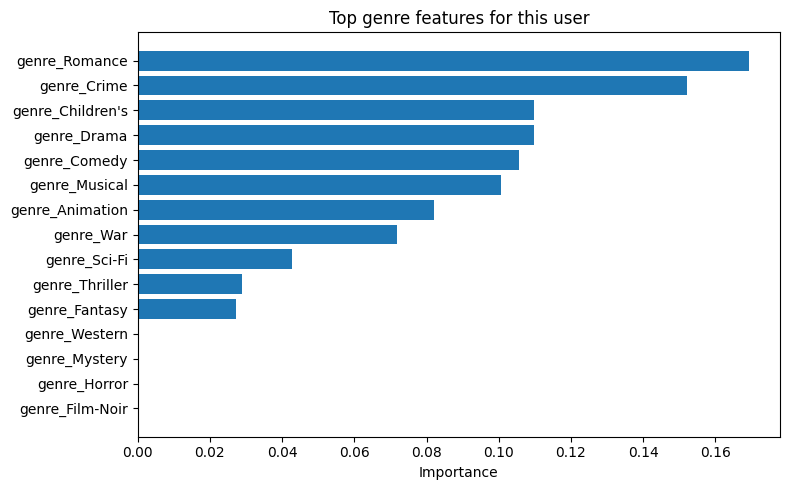

In [10]:
importances = clf.feature_importances_
cols = np.array(train_feature_cols)  # same feature list you used for X

idx = np.argsort(importances)[-15:]  # top 15 features

plt.figure(figsize=(8, 5))
plt.barh(range(len(idx)), importances[idx])
plt.yticks(range(len(idx)), cols[idx])
plt.xlabel("Importance")
plt.title("Top genre features for this user")
plt.tight_layout()
plt.show()


10. 将构建出来的决策树结果打印出来

In [11]:
from sklearn.tree import export_text
print(export_text(clf, feature_names=X.columns.tolist()))

|--- genre_Romance <= 0.50
|   |--- genre_Drama <= 0.50
|   |   |--- genre_Crime <= 0.50
|   |   |   |--- genre_Musical <= 0.50
|   |   |   |   |--- genre_Sci-Fi <= 0.50
|   |   |   |   |   |--- genre_Fantasy <= 0.50
|   |   |   |   |   |   |--- genre_Children's <= 0.50
|   |   |   |   |   |   |   |--- genre_Animation <= 0.50
|   |   |   |   |   |   |   |   |--- genre_Thriller <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- genre_Thriller >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- genre_Animation >  0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- genre_Children's >  0.50
|   |   |   |   |   |   |   |--- genre_Comedy <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- genre_Comedy >  0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- genre_Fantasy >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   | 

In [12]:

def build_features(test, threshold):
    result = test.copy()
    result["label"] = (result["rating"] >= threshold).astype(int)
    return result

test_features = build_features(test_part, threshold=threshold)


11. 对单个用户的测试集进行准确度预测（虽然准确率较低，但是可能是因为本身样本量比较小的原因导致结果较差，因为在后面其实是可以看到在较多用户的情况下，整体的准确率是有60%多的）。

In [13]:
train_feature_cols = (
    [c for c in test_features.columns if  c.startswith("genre_")]
)

X = test_features[train_feature_cols]
y = test_features["label"]
clf.score(X, y)

0.5

12. 对多个用户进行计算预测准确率，如果结果仍较高，证明该方案还是有一定效果的

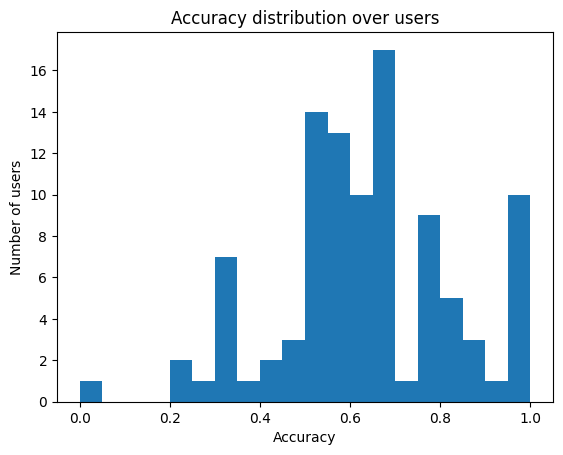

Mean accuracy: 0.63159738906783


In [14]:
def evolution_scores(user_dfs, n):
    scores = []
    for i in range(1, n + 1):
        final_data = user_dfs[i]
        final_data = add_unseen_movies_as_negatives(final_data, movies, n_neg_per_pos=0.2)
        train_part, test_part = split_ramdomly(final_data, split_ratio=0.9)
        train_data, max_rating, min_rating, threshold = label_training_data(train_part)

        train_feature_cols = [c for c in train_data.columns if c.startswith("genre_")]
        X_train = train_data[train_feature_cols]
        y_train = train_data["label"]

        clf = DecisionTreeClassifier(max_depth=15, min_samples_leaf=1, class_weight="balanced")
        clf.fit(X_train, y_train)

        test_features = build_features(test_part, threshold=threshold)
        test_feature_cols = [c for c in test_features.columns if c.startswith("genre_")]
        X_test = test_features[test_feature_cols]
        y_test = test_features["label"]

        scores.append(clf.score(X_test, y_test))
    return scores


scores = evolution_scores(user_dfs, 100)

plt.hist(scores, bins=20)
plt.xlabel("Accuracy")
plt.ylabel("Number of users")
plt.title("Accuracy distribution over users")
plt.show()

print("Mean accuracy:", np.mean(scores))


6040 341
Final user accuracy: 0.6585365853658537


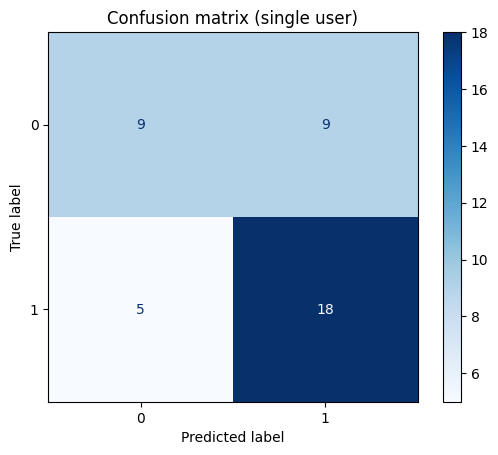

In [15]:
for df in user_dfs:
    max = 0
    result = None
    length = len(user_dfs[df])
    if length > max:
        max = length
        result = df

print(result, max)

final_data = user_dfs[result]
final_data = add_unseen_movies_as_negatives(final_data, movies, n_neg_per_pos=0.2)
train_part, test_part = split_ramdomly(final_data, split_ratio=0.9)
train_data, max_rating, min_rating, threshold = label_training_data(train_part)

train_feature_cols = [c for c in train_data.columns if c.startswith("genre_")]
X_train = train_data[train_feature_cols]
y_train = train_data["label"]

clf = DecisionTreeClassifier(max_depth=15, min_samples_leaf=1, class_weight="balanced")
clf.fit(X_train, y_train)

test_features = build_features(test_part, threshold=threshold)
test_feature_cols = [c for c in test_features.columns if c.startswith("genre_")]
X_test = test_features[test_feature_cols]
y_test = test_features["label"]
print("Final user accuracy:", clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion matrix (single user)")
plt.show()